In [1]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from google.colab import drive
drive.mount('/content/drive/')

Using TensorFlow backend.


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [23]:
#这里读一个已经train好的model
#我这个model很垃圾。
model = load_model('/content/drive/My Drive/ipython notebooks/SemanticSegmentation/FCNN_SEAN_.h5')
#你们这个accuracy比我高
# model = load_model('/content/drive/My Drive/ipython notebooks/SemanticSegmentation/FCNN.h5')
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 473, 473, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 158, 158, 128)     9728      
_________________________________________________________________
batch_normalization_1 (Batch (None, 158, 158, 128)     512       
_________________________________________________________________
activation_1 (Activation)    (None, 158, 158, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 79, 79, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 256)       524544    
_________________________________________________________________
batch_normalization_2 (Batch (None, 40, 40, 256)       1024

In [24]:
#这里按自己的directory设置好了。我是mount在collab上以后做的。
#400张被preprocess好的图。np读进来就好。
data_loading_time_start = time.time()
dir_train_img = '/content/drive/My Drive/ipython notebooks/SemanticSegmentation/2007_training_images.npy'
dir_seg_img = '/content/drive/My Drive/ipython notebooks/SemanticSegmentation/2007_segmented_images.npy'
train_images = np.load(dir_train_img)
seg_images_21 = np.load(dir_seg_img)
print(f'Total time to load data: {time.time() - data_loading_time_start}s')
print(train_images.shape)
print(seg_images_21.shape)

Total time to load data: 6.9553542137146s
(400, 473, 473, 3)
(400, 473, 473, 21)


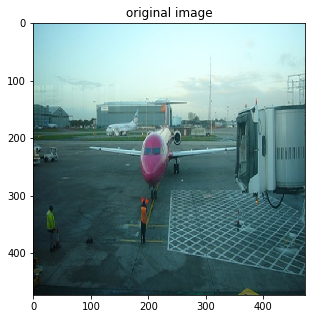

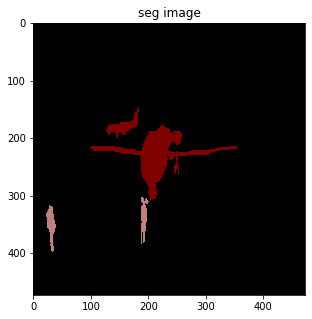

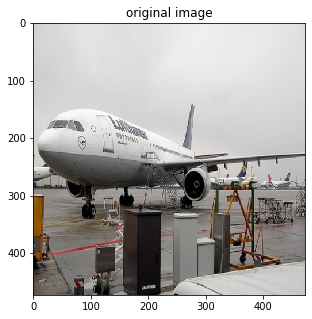

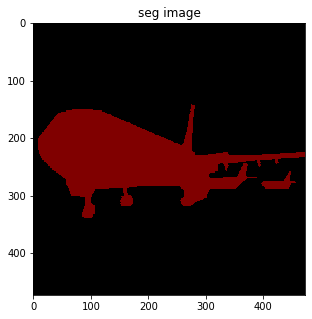

In [31]:
#检查一下，读进来了没有
# mapping the 3rd dimension in segmented images
# Saved in the d2l package for later use
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
# Saved in the d2l package for later use
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']
# Border color to be ignored for now
border_color = [224, 224, 192]
back_ground_color = VOC_COLORMAP[0]
class_dic = {}
for i,j in enumerate(VOC_CLASSES):
    class_dic[i] = j

def map_rgb_to_one_of_21_classes(RGB_val):
    RGB_val = list(RGB_val)
    final_dim = np.zeros(21)
    if RGB_val == border_color or RGB_val == back_ground_color:
      return final_dim
    color_map_index = VOC_COLORMAP.index(list(RGB_val))
    final_dim[color_map_index] = 1
    return final_dim

def map_21_classes_back_to_rgb(size_21_array):
    rgb_color_index = np.argmax(size_21_array)
    rgb_color = VOC_COLORMAP[rgb_color_index]
    return rgb_color

def map_segmented_images_to_21_classes(seg_images):
    for i in range(len(seg_images)):
        row = seg_images[i].shape[0]
        col = seg_images[i].shape[1]
        seg = seg_images[i].copy()
        seg.resize(row, col, 21)
        for x in range(row):
          for y in range(col):
              seg[x,y] = map_rgb_to_one_of_21_classes(seg_images[i][x, y])
        seg_images[i] = seg      
    return seg_images
  
def map_21_class_tensor_back_to_rgb(tens):
    for i in range(len(tens)):
        row = tens[i].shape[0]
        col = tens[i].shape[1]
        seg = tens[i].copy()
        seg.resize(row, col, 3)
        for x in range(row):
          for y in range(col):
              seg[x,y] = map_21_classes_back_to_rgb(tens[i][x, y])
        tens[i] = seg
    return tens
    
i = 0
while i < 2:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(train_images[i])
    ax.set_title("original image")
    plt.show()
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(map_21_class_tensor_back_to_rgb([seg_images_21[i]])[0])
    ax.set_title("seg image")
    plt.show()
    i += 1

#这里也证明我从21class还原rgb的function没有写错。

In [0]:
display_number = 4
x = np.array(train_images[0:display_number])
y = np.array(seg_images_21[0:display_number]) 

In [27]:
k = model.evaluate(x, y, batch_size=1)
print(k)

4/4 [==============================] - 1s 240ms/step
[0.5933180786669254, 0.0233016274869442]


In [28]:
our_segmentation_preds = model.predict(x)
print(our_segmentation_preds.shape)

(4, 473, 473, 21)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


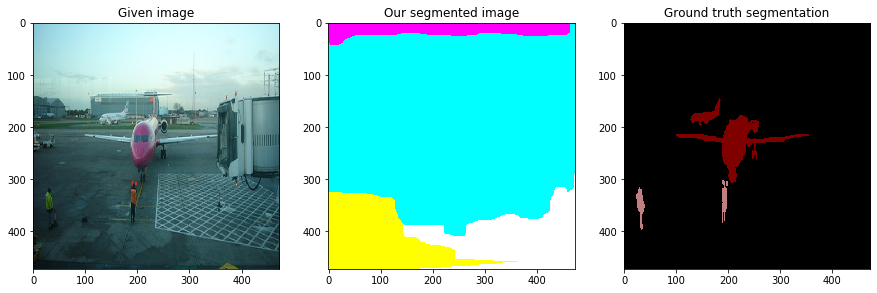

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


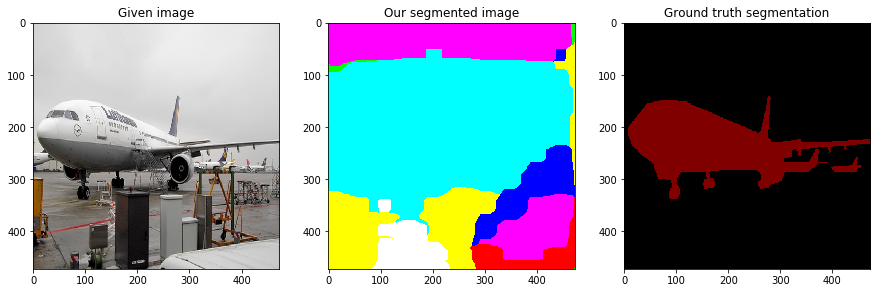

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


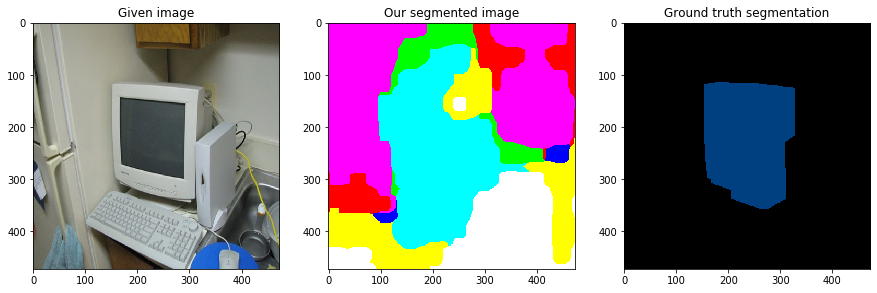

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


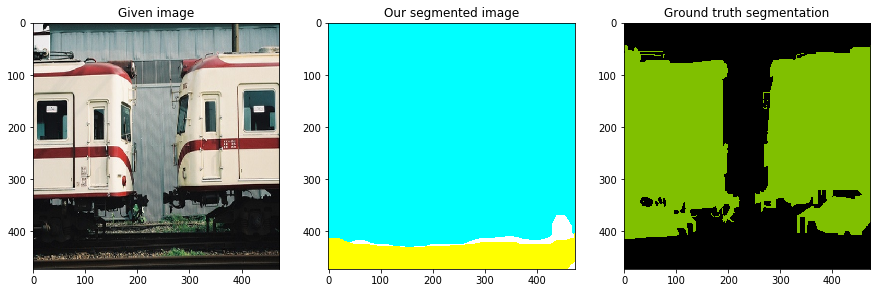

In [29]:
our_segmentation_rgb = map_21_class_tensor_back_to_rgb(list(our_segmentation_preds))
seg_image_rgb = map_21_class_tensor_back_to_rgb(list(y))

for i in range(display_number):
  fig, axisList = plt.subplots(nrows=1, ncols=3)
  fig.set_size_inches(15, 5)
  orig_axis = axisList[0]
  our_seg_axis = axisList[1]
  ground_seg_axis = axisList[2]

  orig_axis.imshow(train_images[i])
  orig_axis.set_title("Given image")

  our_seg_axis.imshow(our_segmentation_rgb[i])
  our_seg_axis.set_title("Our segmented image")
  
  ground_seg_axis.imshow(seg_image_rgb[i])
  ground_seg_axis.set_title("Ground truth segmentation")

  plt.show()
  i += 1